In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat
     

Streaming output truncated to the last 5000 lines.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian

In [ ]:
dataset = "./annotations/list.txt"
lines = open(dataset,"r").readlines() 
lines = [line for line in lines if line[0]!= "#" ]
lines = [line for line in lines if line.split(" ")[2] == "1"]
len(lines)

2371

In [ ]:
from sklearn.model_selection import train_test_split 
train,test = train_test_split(lines[0:500],test_size=0.20,random_state=32,shuffle=True)
train,val = train_test_split(train,test_size=0.30,random_state=32,shuffle=True)
len(train),len(test),len(val)

(280, 100, 120)

In [ ]:
train[0]

'Persian_140 24 1 8\n'

In [ ]:
!pip install albumentations segmentation_models_pytorch wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 61.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 25.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.1/189.1 KB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=b4d3b38d809c8ad331237

In [ ]:
import segmentation_models_pytorch as smp 
model = smp.Unet("resnet34")
model.eval()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
torch.manual_seed(0)
import cv2
import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2 

class PetsDataset(Dataset):
    def __init__(self, lines, root ="./", transforms=[],target_size=512):
        self.root = root
        self.transforms = [A.LongestMaxSize(target_size),A.PadIfNeeded(target_size,target_size,border_mode=cv2.BORDER_CONSTANT,value=0)] + transforms + [ToTensorV2()]
        self.transforms = A.Compose(self.transforms)        
        self.img_names = [line.split(" ")[0] for line in lines]

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = self.root + f"images/{img_name}.jpg"
        mask_path = self.root + f"annotations/trimaps/{img_name}.png"
        img = Image.open(img_path)

        mask = np.array(Image.open(mask_path))
        # print(mask.min())
        # mask = mask[:,:,0]
        mask = (mask !=2).astype('int')
        img = np.array(img)
        transformed = self.transforms(image=img,mask=mask)
        img,mask = transformed['image'],transformed['mask']

        img = img/255.0
        return img,mask.unsqueeze(0)

    def __len__(self):
        return len(self.img_names)

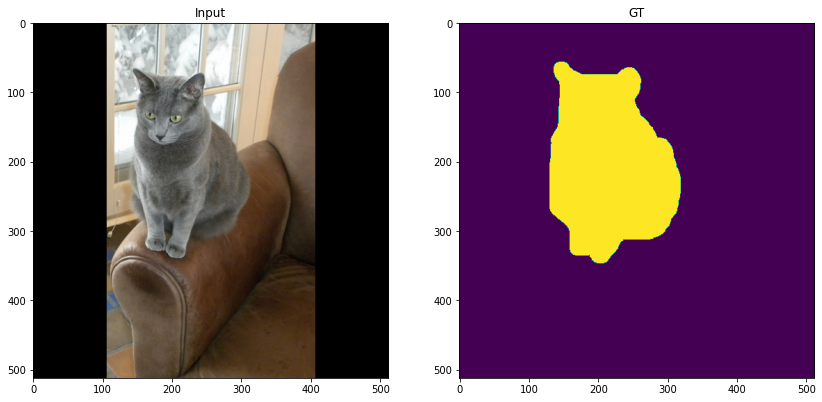

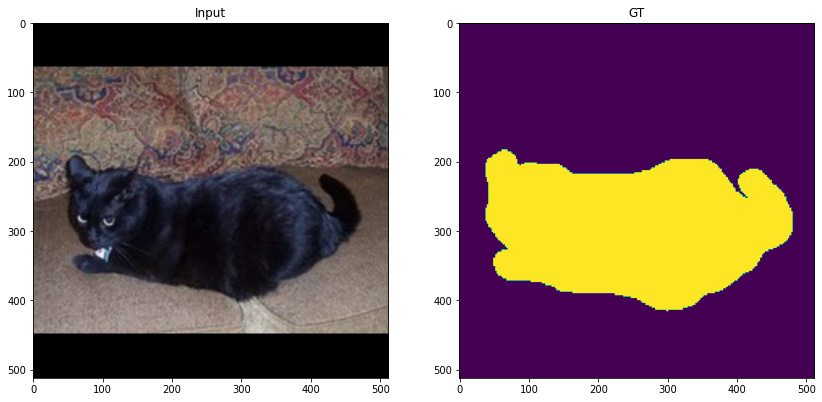

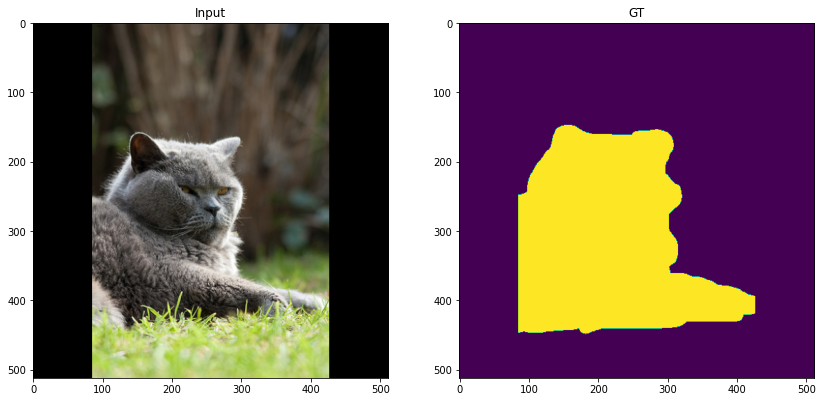

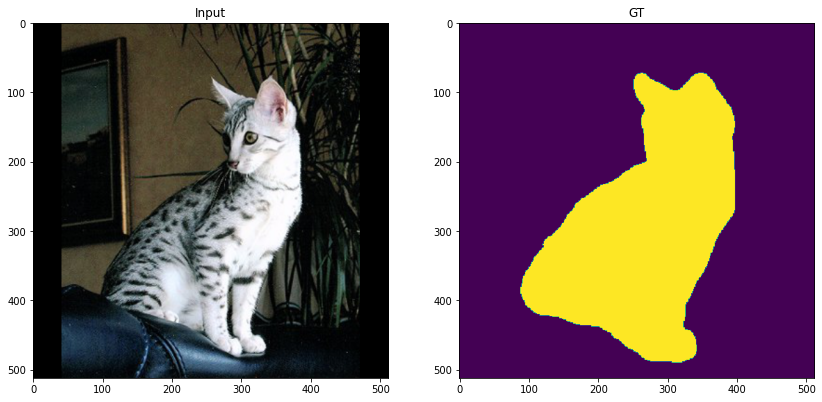

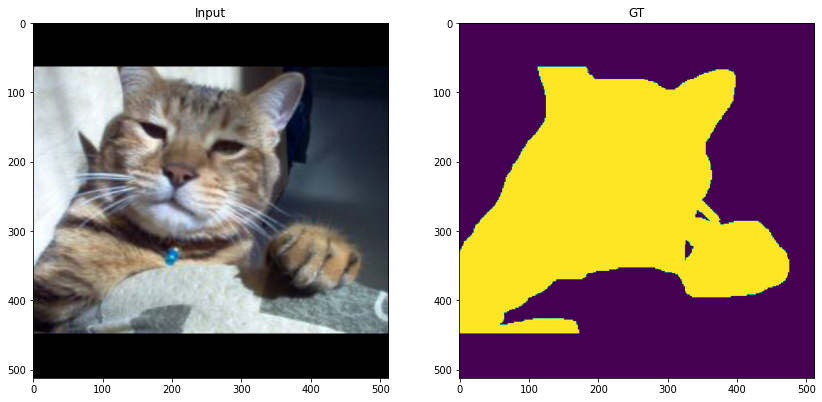

In [ ]:
import matplotlib.pyplot as plt 
ds = PetsDataset(train) 
import random
# dummy_loader = DataLoader(test_set, batch_size=1, shuffle=True)
for i in range(5):
  img,mask = random.choice(ds)
  fig,ax = plt.subplots(1,2,figsize=(14,14))
  ax[0].imshow(img.permute(1,2,0))
  ax[0].set_title("Input")

  ax[1].imshow(mask.permute(1,2,0))
  ax[1].set_title("GT")


In [ ]:
import argparse
import logging
import sys
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import os
import gc
from sklearn.metrics import recall_score,f1_score,precision_score,accuracy_score

import torch

def calculate_iou_coeff(pred, target, smooth=1e-5):
    # Flatten predictions and targets
    pred = pred.view(-1)
    target = target.view(-1)

    # Calculate intersection and union
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection

    # Calculate IoU score
    score = (intersection + smooth) / (union + smooth)
    return score


def evaluate_metrics(net, dataloader, device):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0
    iou_score= 0 
    acc = 0
    prec = 0
    recall = 0
    f1= 0
    for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=False):
        image, mask_true = batch
        image = image.to(device=device, dtype=torch.float32)
        with torch.no_grad():
            mask_pred = net(image)
            mask_pred = (torch.sigmoid(mask_pred.squeeze(1))>0.5).float()
            mask_pred = mask_pred.to('cpu')
            iou_score += calculate_iou_coeff(mask_true.float(),mask_pred).item()
            f1 += f1_score(mask_true.view(-1),mask_pred.view(-1))
            prec += precision_score(mask_true.view(-1),mask_pred.view(-1))
            acc += accuracy_score(mask_true.view(-1),mask_pred.view(-1))
            recall += recall_score(mask_true.view(-1),mask_pred.view(-1))
            

    dice_score /= num_val_batches 
    iou_score /= num_val_batches 
    acc /= num_val_batches
    prec /= num_val_batches
    recall /= num_val_batches
    f1 /= num_val_batches
    print("F1 Score:",f1)
    print("Precision Score:",prec)
    print("IoU Score:",iou_score)
    print("Recall Score:",recall)
    print("Accuracy Score:",acc)

    
    
def evaluate_score(net, dataloader, device):
    net.eval()
    num_val_batches = len(dataloader)
    iou_score = 0
    for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=False):
        image, mask_true = batch
        image = image.to(device=device, dtype=torch.float32)
        mask_true = mask_true.to(device=device)
        with torch.no_grad():
            mask_pred = net(image)
            mask_pred = (torch.sigmoid(mask_pred)>0.5).float()
            score = calculate_iou_coeff(mask_pred, mask_true.float())
            iou_score += score.item()
    if num_val_batches == 0:
        return iou_score
    return iou_score / num_val_batches

def training( net,device,training_data,validation_data,dir_checkpoint=None,
              epochs: int = 5,
              batch_size: int = 1,
              learning_rate: float = 1e-5,
              save_checkpoint: bool = True,
              img_scale: float = 1,
              amp: bool = True,
              loss_fn = nn.BCEWithLogitsLoss()):

    
    if dir_checkpoint == None:
        dir_checkpoint = Path('./results')
    else:
        dir_checkpoint = Path(dir_checkpoint)

    net.to(device)
    n_train = len(training_data)
    n_val = len(validation_data)
    

    loader_args = dict(batch_size=batch_size, pin_memory=False)
    train_loader = DataLoader(training_data, shuffle=True,**loader_args)
    val_loader = DataLoader(validation_data, shuffle=False,batch_size=batch_size)

    # (Initialize logging)
    experiment = wandb.init(project='Demo', resume='allow', anonymous='must',dir="wandb_logs")
    experiment.config.update(dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
                                   save_checkpoint=save_checkpoint, img_scale=img_scale,
                                  amp=amp))
    best_score = 0.0 
    best_epoch = 0
    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Device:          {device.type}
        Log Dir: {str(dir_checkpoint)}
        Loss function: {str(loss_fn)}
    ''')

    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='max',patience=2)
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = loss_fn
    global_step = 0

    for epoch in range(1, epochs+1):
        net.train()
        epoch_loss = 0
        epoch_step = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for images,true_masks in train_loader:


                images = images.to(device=device, dtype=torch.float32)
                true_masks = true_masks.to(device=device)

                with torch.cuda.amp.autocast(enabled=amp):
                    masks_pred = net(images)
                    loss = criterion(masks_pred, true_masks.float())

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                epoch_step += 1
                pbar.set_postfix(**{'loss (batch)': loss.item()})
                del images,true_masks,masks_pred
                gc.collect()
        # Evaluation round

        val_score = evaluate_score(net, val_loader, device)
        experiment.log({
                    'learning rate': optimizer.param_groups[0]['lr'],
                    'iou score': val_score,
                    'step': global_step,
                    'epoch': epoch
                })
        scheduler.step(val_score)
        if val_score > best_score:
            best_score = val_score 
            best_epoch = epoch
            Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
            torch.save(net.state_dict(), str(dir_checkpoint / 'best_model.pth'.format(epoch)))
        
        
        print('Validation dice score: {}'.format(val_score))
        #save checkpoint
        # torch.save(net.state_dict(), str(dir_checkpoint / 'checkpoint.pth'.format(epoch)))

    print(f"Best score {best_score} at epoch {best_epoch}")
    wandb.finish()


In [ ]:
import segmentation_models_pytorch as smp 

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')
train_set = PetsDataset(train)
val_set = PetsDataset(val)
dir_checkpoint = './results'
model = smp.Unet("resnet34")
training(model,dir_checkpoint=dir_checkpoint,epochs=50,training_data=train_set,validation_data=val_set,
              batch_size=16,learning_rate=2e-3,
              device=device)
wandb.finish()

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,██▅▅▄▃▂▃▃▃▃▃▃▄▄▃▃▃▂▂▂▄▃▂▂▂▁▂▂▂▁▂▂▂▂▂▂▁▁▂
epoch,1
step,78
train loss,0.27415


Epoch 1/50: 100%|██████████| 280/280 [00:12<00:00, 22.21img/s, loss (batch)=0.362]


Validation dice score: 0.3953932225704193


Epoch 2/50: 100%|██████████| 280/280 [00:13<00:00, 21.00img/s, loss (batch)=0.306]


Validation dice score: 0.5466680862009525


Epoch 3/50: 100%|██████████| 280/280 [00:14<00:00, 19.50img/s, loss (batch)=0.306]


Validation dice score: 0.5945793017745018


Epoch 4/50: 100%|██████████| 280/280 [00:12<00:00, 22.02img/s, loss (batch)=0.326]


Validation dice score: 0.08650371944531798


Epoch 5/50: 100%|██████████| 280/280 [00:12<00:00, 21.77img/s, loss (batch)=0.229]


Validation dice score: 0.6200693026185036


Epoch 6/50: 100%|██████████| 280/280 [00:12<00:00, 22.74img/s, loss (batch)=0.23]


Validation dice score: 0.684975691139698


Epoch 7/50: 100%|██████████| 280/280 [00:12<00:00, 21.56img/s, loss (batch)=0.215]


Validation dice score: 0.6784359663724899


Epoch 8/50: 100%|██████████| 280/280 [00:13<00:00, 20.64img/s, loss (batch)=0.298]


Validation dice score: 0.708538107573986


Epoch 9/50: 100%|██████████| 280/280 [00:13<00:00, 20.39img/s, loss (batch)=0.174]


Validation dice score: 0.696400947868824


Epoch 10/50: 100%|██████████| 280/280 [00:13<00:00, 20.26img/s, loss (batch)=0.319]


Validation dice score: 0.7187334597110748


Epoch 11/50: 100%|██████████| 280/280 [00:15<00:00, 18.45img/s, loss (batch)=0.195]


Validation dice score: 0.717917874455452


Epoch 12/50: 100%|██████████| 280/280 [00:15<00:00, 18.41img/s, loss (batch)=0.233]


Validation dice score: 0.7011181861162186


Epoch 13/50: 100%|██████████| 280/280 [00:15<00:00, 18.30img/s, loss (batch)=0.166]


Validation dice score: 0.6506530344486237


Epoch 14/50: 100%|██████████| 280/280 [00:16<00:00, 17.28img/s, loss (batch)=0.141]


Validation dice score: 0.7773480042815208


Epoch 15/50: 100%|██████████| 280/280 [00:15<00:00, 17.72img/s, loss (batch)=0.144]


Validation dice score: 0.7904222011566162


Epoch 16/50: 100%|██████████| 280/280 [00:14<00:00, 19.58img/s, loss (batch)=0.185]


Validation dice score: 0.7980577051639557


Epoch 17/50: 100%|██████████| 280/280 [00:16<00:00, 16.99img/s, loss (batch)=0.194]


Validation dice score: 0.8082173317670822


Epoch 18/50: 100%|██████████| 280/280 [00:15<00:00, 18.22img/s, loss (batch)=0.123]


Validation dice score: 0.8101004585623741


Epoch 19/50: 100%|██████████| 280/280 [00:13<00:00, 20.12img/s, loss (batch)=0.0974]


Validation dice score: 0.8114866018295288


Epoch 20/50: 100%|██████████| 280/280 [00:16<00:00, 16.60img/s, loss (batch)=0.109]


Validation dice score: 0.8137833625078201


Epoch 21/50: 100%|██████████| 280/280 [00:14<00:00, 19.13img/s, loss (batch)=0.108]


Validation dice score: 0.811225101351738


Epoch 22/50: 100%|██████████| 280/280 [00:14<00:00, 18.96img/s, loss (batch)=0.184]


Validation dice score: 0.8134753555059433


Epoch 23/50: 100%|██████████| 280/280 [00:15<00:00, 18.14img/s, loss (batch)=0.0827]


Validation dice score: 0.8088820725679398


Epoch 24/50: 100%|██████████| 280/280 [00:14<00:00, 19.91img/s, loss (batch)=0.0975]


Validation dice score: 0.8123159855604172


Epoch 25/50: 100%|██████████| 280/280 [00:14<00:00, 18.85img/s, loss (batch)=0.0821]


Validation dice score: 0.8148834109306335


Epoch 26/50: 100%|██████████| 280/280 [00:12<00:00, 21.62img/s, loss (batch)=0.0742]


Validation dice score: 0.8152624443173409


Epoch 27/50: 100%|██████████| 280/280 [00:12<00:00, 21.82img/s, loss (batch)=0.0729]


Validation dice score: 0.8156905174255371


Epoch 28/50: 100%|██████████| 280/280 [00:12<00:00, 21.71img/s, loss (batch)=0.0923]


Validation dice score: 0.8177948892116547


Epoch 29/50: 100%|██████████| 280/280 [00:12<00:00, 22.08img/s, loss (batch)=0.0649]


Validation dice score: 0.8190031424164772


Epoch 30/50: 100%|██████████| 280/280 [00:12<00:00, 21.57img/s, loss (batch)=0.318]


Validation dice score: 0.8179293647408485


Epoch 31/50: 100%|██████████| 280/280 [00:13<00:00, 21.02img/s, loss (batch)=0.081]


Validation dice score: 0.818825252354145


Epoch 32/50: 100%|██████████| 280/280 [00:12<00:00, 21.61img/s, loss (batch)=0.0847]


Validation dice score: 0.8194822743535042


Epoch 33/50: 100%|██████████| 280/280 [00:12<00:00, 21.87img/s, loss (batch)=0.0964]


Validation dice score: 0.8188894912600517


Epoch 34/50: 100%|██████████| 280/280 [00:12<00:00, 21.67img/s, loss (batch)=0.101]


Validation dice score: 0.8184720501303673


Epoch 35/50: 100%|██████████| 280/280 [00:12<00:00, 21.67img/s, loss (batch)=0.111]


Validation dice score: 0.8183626681566238


Epoch 36/50: 100%|██████████| 280/280 [00:13<00:00, 20.18img/s, loss (batch)=0.0866]


Validation dice score: 0.8192623555660248


Epoch 37/50: 100%|██████████| 280/280 [00:12<00:00, 22.17img/s, loss (batch)=0.105]


Validation dice score: 0.8185838535428047


Epoch 38/50: 100%|██████████| 280/280 [00:12<00:00, 21.79img/s, loss (batch)=0.262]


Validation dice score: 0.8187162950634956


Epoch 39/50: 100%|██████████| 280/280 [00:12<00:00, 22.35img/s, loss (batch)=0.12]


Validation dice score: 0.818400539457798


Epoch 40/50: 100%|██████████| 280/280 [00:12<00:00, 21.86img/s, loss (batch)=0.082]


Validation dice score: 0.8182873427867889


Epoch 41/50: 100%|██████████| 280/280 [00:12<00:00, 21.63img/s, loss (batch)=0.0969]


Validation dice score: 0.8177904710173607


Epoch 42/50: 100%|██████████| 280/280 [00:12<00:00, 21.80img/s, loss (batch)=0.0614]


Validation dice score: 0.8187933713197708


Epoch 43/50: 100%|██████████| 280/280 [00:12<00:00, 21.94img/s, loss (batch)=0.122]


Validation dice score: 0.8178772777318954


Epoch 44/50: 100%|██████████| 280/280 [00:12<00:00, 22.13img/s, loss (batch)=0.0861]


Validation dice score: 0.8184455931186676


Epoch 45/50: 100%|██████████| 280/280 [00:12<00:00, 22.13img/s, loss (batch)=0.0793]


Validation dice score: 0.8187828660011292


Epoch 46/50: 100%|██████████| 280/280 [00:12<00:00, 21.97img/s, loss (batch)=0.116]


Validation dice score: 0.8181870058178902


Epoch 47/50: 100%|██████████| 280/280 [00:12<00:00, 22.07img/s, loss (batch)=0.114]


Validation dice score: 0.8188865780830383


Epoch 48/50: 100%|██████████| 280/280 [00:12<00:00, 21.99img/s, loss (batch)=0.0868]


Validation dice score: 0.8183789700269699


Epoch 49/50: 100%|██████████| 280/280 [00:12<00:00, 22.04img/s, loss (batch)=0.0688]


Validation dice score: 0.8189733400940895


Epoch 50/50: 100%|██████████| 280/280 [00:12<00:00, 21.95img/s, loss (batch)=0.0683]


Validation dice score: 0.818522036075592
Best score 0.8194822743535042 at epoch 32


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iou score,▄▅▆▁▇▇▇▇▇▇▆█████████████████████████████
learning rate,███████████▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▆▆▅▅▅▄▄▄▃▂▂▂▂▂▁▂▁▁▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
epoch,50
iou score,0.81852
learning rate,0.0
step,900
train loss,0.0683


In [ ]:
import segmentation_models_pytorch as smp 

model = smp.Unet("resnet34")
model.load_state_dict(torch.load("./results/best_model.pth"))

<All keys matched successfully>

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
test_set = PetsDataset(test)
test_loader = DataLoader(test_set,batch_size=16)
evaluate_metrics(model,test_loader,device) 

F1 Score: 0.9033528975035097
Precision Score: 0.906405874308609
IoU Score: 0.8245974693979535
Recall Score: 0.9006168719994259
Accuracy Score: 0.9288100515093122


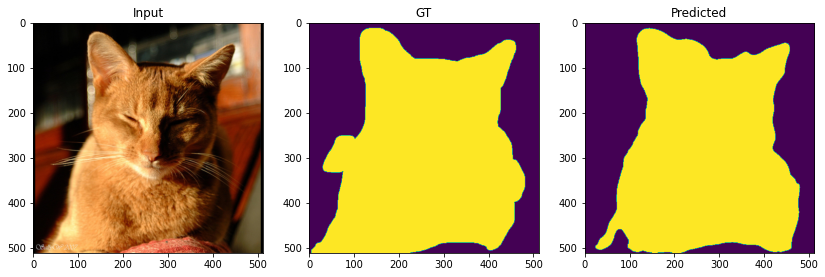

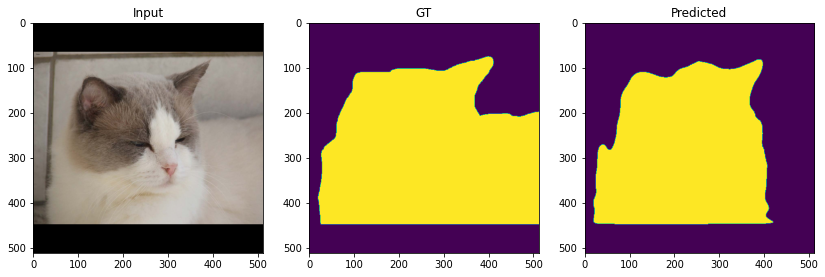

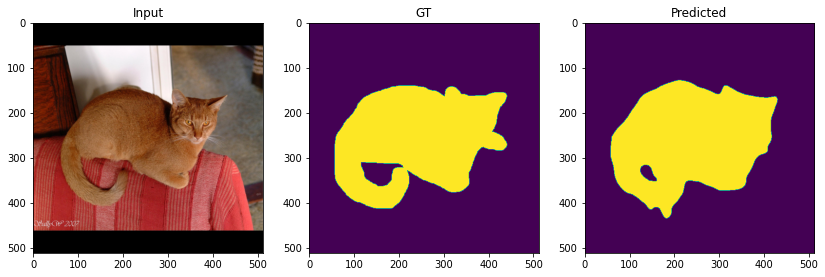

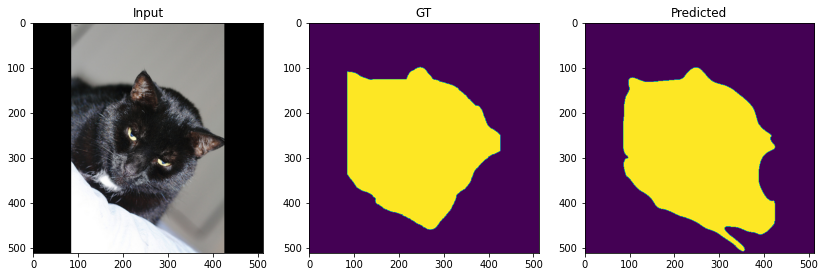

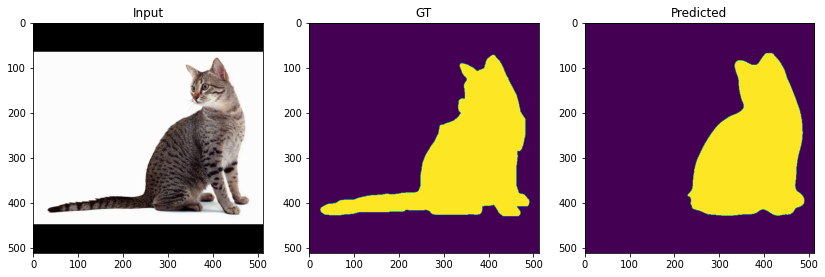

In [ ]:
import random
device = "cpu"
model.to("cpu")
# check = random.sample(test_set,5)
# dummy_loader = DataLoader(test_set, batch_size=1, shuffle=True)
for i in range(5):
  img,mask = random.choice(test_set)
  fig,ax = plt.subplots(1,3,figsize=(14,14))
  with torch.no_grad():
    prediction = model(img[None])[0]
    prediction = (prediction.sigmoid()>0.5).float()
    prediction = prediction.squeeze(0)
  ax[0].imshow(img.permute(1,2,0))
  ax[0].set_title("Input")

  ax[1].imshow(mask.permute(1,2,0))
  ax[1].set_title("GT")

  ax[2].imshow(prediction)
  ax[2].set_title("Predicted")
  plt.show()

In [ ]:
ftr = torch.randn(65,25,25)
ftr.shape

torch.Size([65, 25, 25])